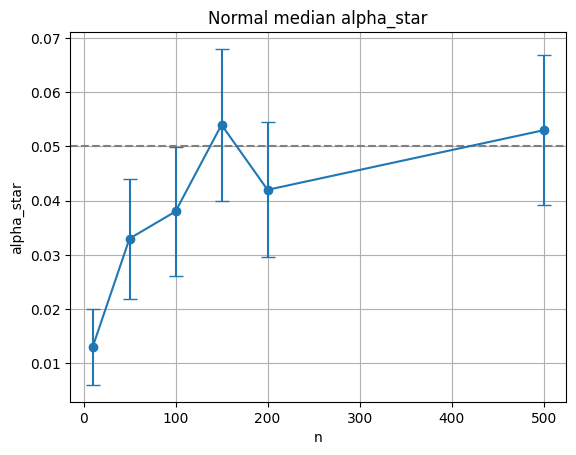

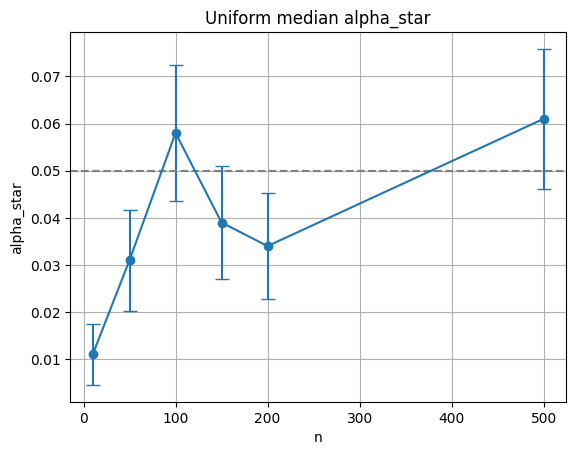

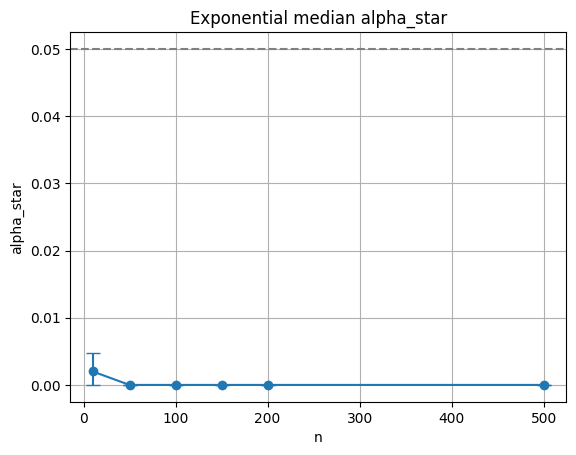

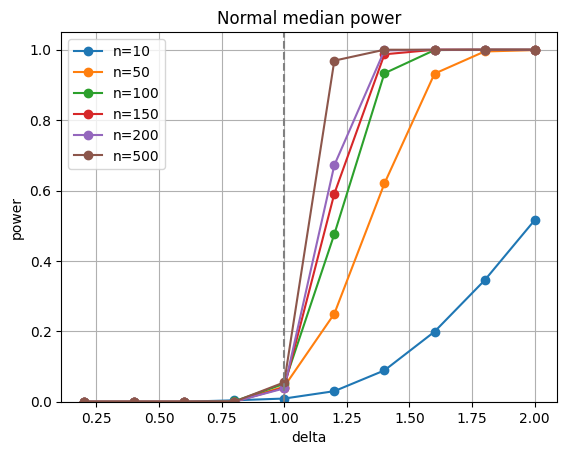

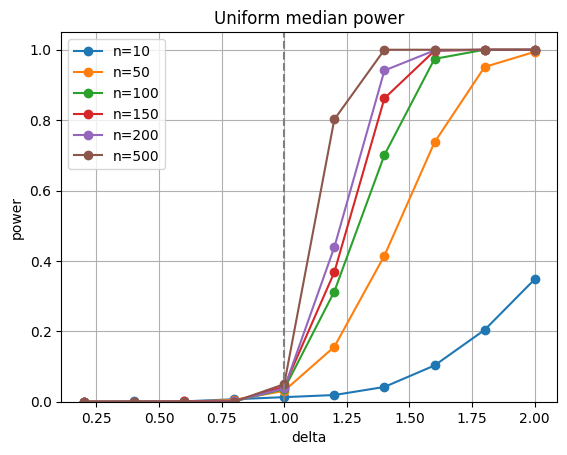

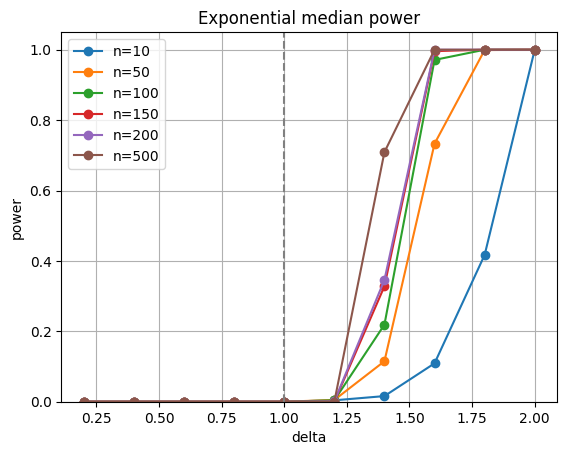

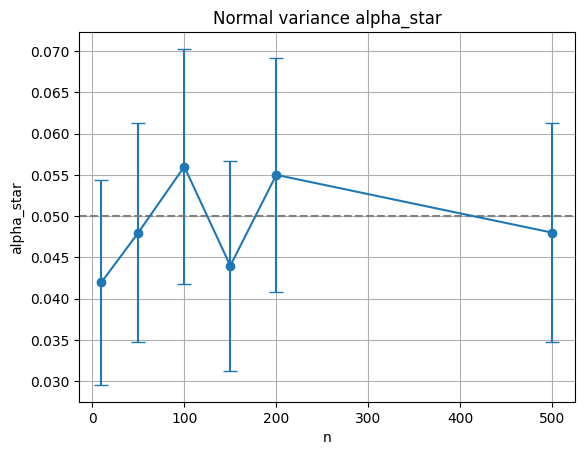

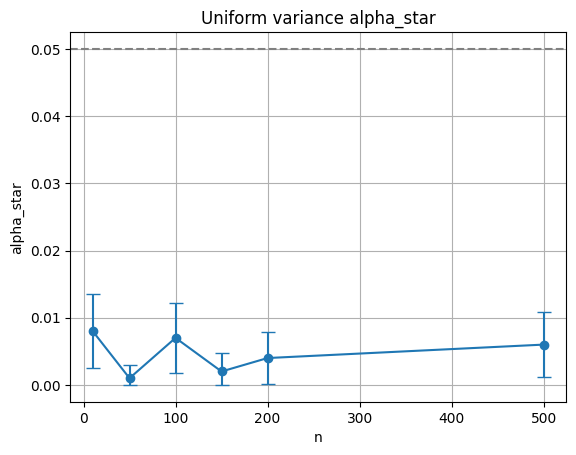

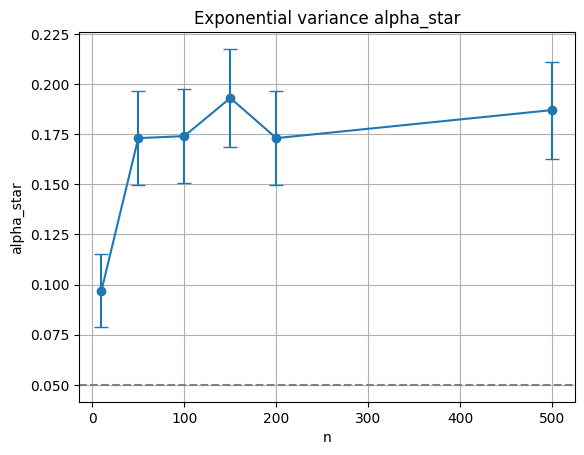

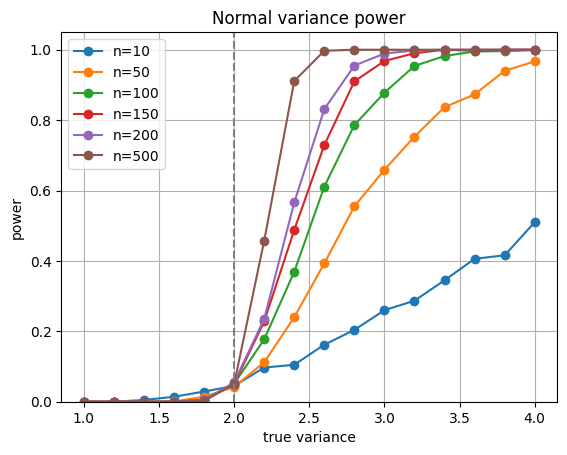

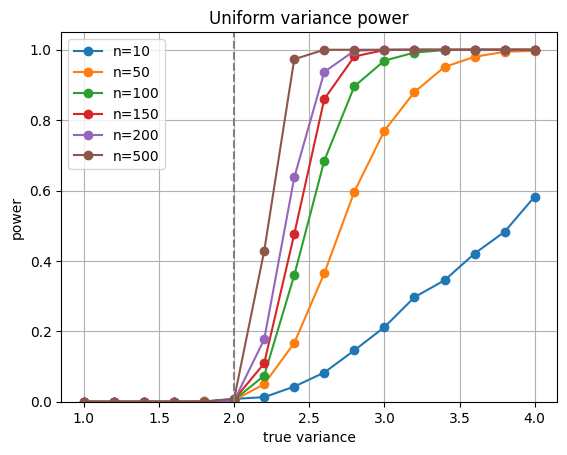

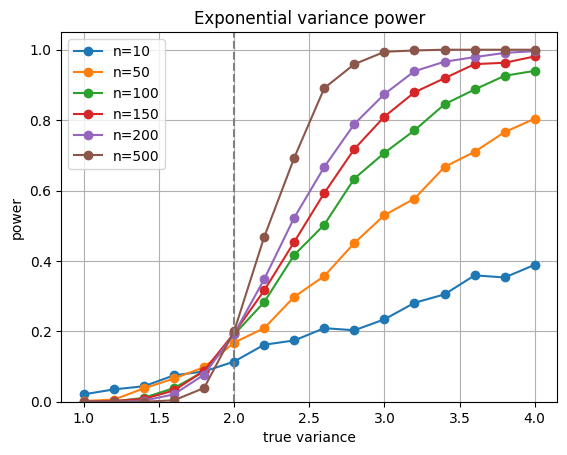

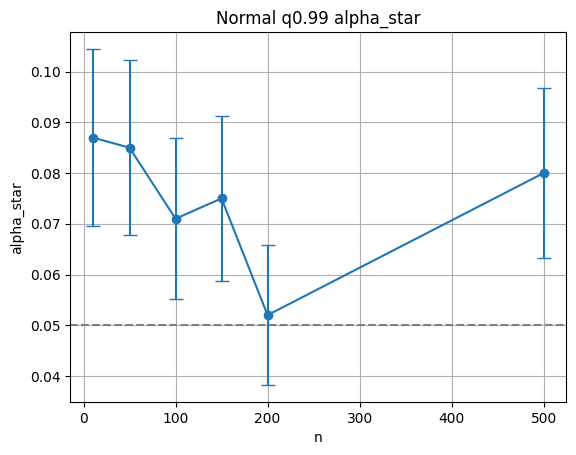

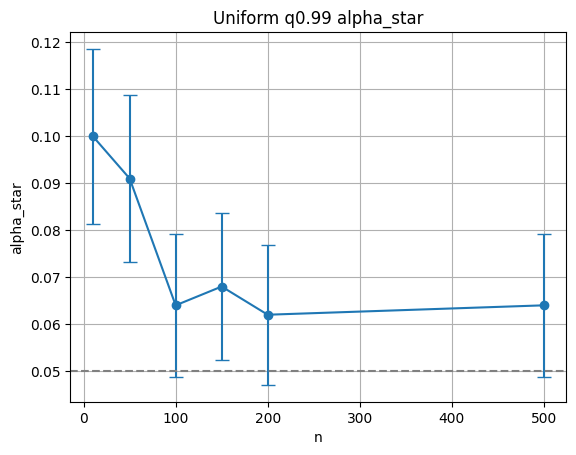

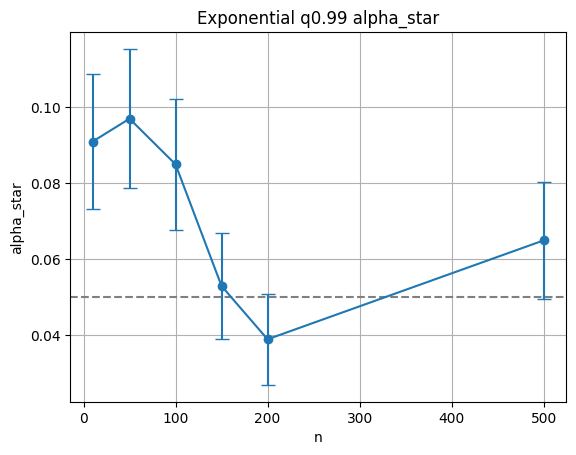

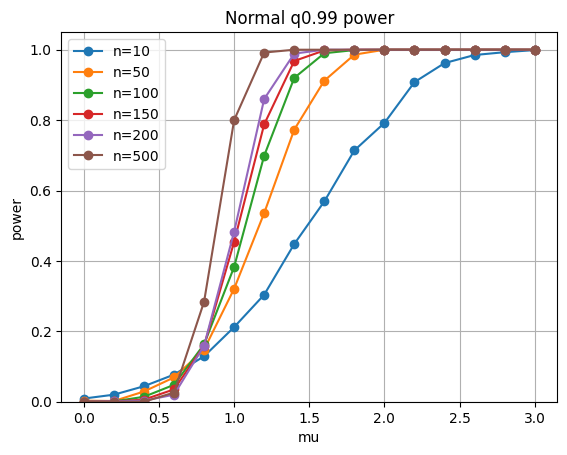

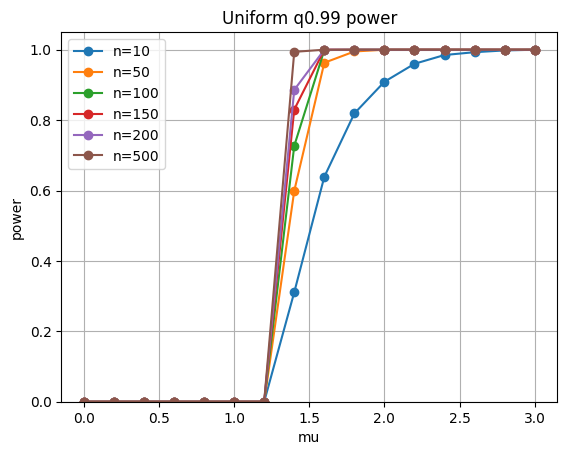

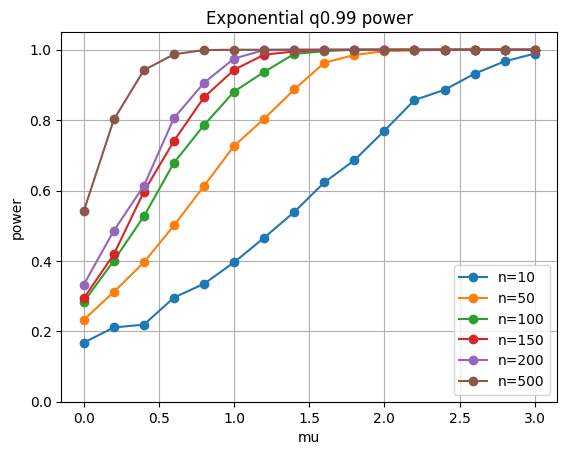

In [2]:
import math
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

N = 1000
ns = [10, 50, 100, 150, 200, 500]
alpha = 0.05

z_095 = st.norm.ppf(0.975)

def binom_ci_wald(phat, N, z=z_095):
    se = math.sqrt(max(0.0, phat * (1.0 - phat) / N))
    lo = max(0.0, phat - z * se)
    hi = min(1.0, phat + z * se)
    return lo, hi

def gen_normal(n):
    return rng.normal(0.0, 1.0, size=n)

def gen_uniform(n):
    a = -math.sqrt(3.0)
    b =  math.sqrt(3.0)
    return rng.uniform(a, b, size=n)

def gen_exponential(n):
    return rng.exponential(scale=1.0, size=n) - 1.0

dists = {
    "Normal": gen_normal,
    "Uniform": gen_uniform,
    "Exponential": gen_exponential
}

a_med = 1.0
deltas = np.arange(0.2, 2.0 * a_med + 0.001, 0.2)

def sign_test_median_reject(x, a, alpha=0.05):
    n = len(x)
    k = int(np.sum(x > a))
    p_value = 1.0 - st.binom.cdf(k - 1, n, 0.5)
    return p_value < alpha

def simulate_alpha_star_median(gen):
    alpha_star = []
    ci_lo = []
    ci_hi = []
    for n in ns:
        rej = 0
        for _ in range(N):
            x = gen(n) + a_med
            if sign_test_median_reject(x, a_med, alpha):
                rej += 1
        phat = rej / N
        lo, hi = binom_ci_wald(phat, N)
        alpha_star.append(phat)
        ci_lo.append(lo)
        ci_hi.append(hi)
    return np.array(alpha_star), np.array(ci_lo), np.array(ci_hi)

def simulate_power_median(gen, n):
    power = []
    for delta in deltas:
        rej = 0
        for _ in range(N):
            x = gen(n) + delta
            if sign_test_median_reject(x, a_med, alpha):
                rej += 1
        power.append(rej / N)
    return np.array(power)

median_alpha_results = {}
median_power_results = {}

for name, gen in dists.items():
    median_alpha_results[name] = simulate_alpha_star_median(gen)
    median_power_results[name] = {n: simulate_power_median(gen, n) for n in ns}

for name in dists.keys():
    a_star, lo, hi = median_alpha_results[name]
    plt.figure()
    plt.errorbar(ns, a_star, yerr=[a_star - lo, hi - a_star], fmt="o-", capsize=5)
    plt.axhline(alpha, linestyle="--", color="gray")
    plt.xlabel("n")
    plt.ylabel("alpha_star")
    plt.title(name + " median alpha_star")
    plt.grid(True)
    plt.show()

for name in dists.keys():
    plt.figure()
    for n in ns:
        plt.plot(deltas, median_power_results[name][n], marker="o", label="n=" + str(n))
    plt.axvline(a_med, linestyle="--", color="gray")
    plt.xlabel("delta")
    plt.ylabel("power")
    plt.title(name + " median power")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

sigma0_sq = 2.0
sigmas_true = np.arange(1.0, 2.0 * sigma0_sq + 0.001, 0.2)

def chi_square_variance_reject(x, sigma0_sq, alpha=0.05):
    n = len(x)
    s2 = float(np.var(x, ddof=1))
    chi2 = (n - 1) * s2 / sigma0_sq
    crit = st.chi2.ppf(1.0 - alpha, df=n - 1)
    return chi2 > crit

def simulate_alpha_star_variance(gen):
    alpha_star = []
    ci_lo = []
    ci_hi = []
    for n in ns:
        rej = 0
        scale = math.sqrt(sigma0_sq)
        for _ in range(N):
            x = gen(n) * scale
            if chi_square_variance_reject(x, sigma0_sq, alpha):
                rej += 1
        phat = rej / N
        lo, hi = binom_ci_wald(phat, N)
        alpha_star.append(phat)
        ci_lo.append(lo)
        ci_hi.append(hi)
    return np.array(alpha_star), np.array(ci_lo), np.array(ci_hi)

def simulate_power_variance(gen, n):
    power = []
    for vtrue in sigmas_true:
        scale = math.sqrt(vtrue)
        rej = 0
        for _ in range(N):
            x = gen(n) * scale
            if chi_square_variance_reject(x, sigma0_sq, alpha):
                rej += 1
        power.append(rej / N)
    return np.array(power)

var_alpha_results = {}
var_power_results = {}

for name, gen in dists.items():
    var_alpha_results[name] = simulate_alpha_star_variance(gen)
    var_power_results[name] = {n: simulate_power_variance(gen, n) for n in ns}

for name in dists.keys():
    a_star, lo, hi = var_alpha_results[name]
    plt.figure()
    plt.errorbar(ns, a_star, yerr=[a_star - lo, hi - a_star], fmt="o-", capsize=5)
    plt.axhline(alpha, linestyle="--", color="gray")
    plt.xlabel("n")
    plt.ylabel("alpha_star")
    plt.title(name + " variance alpha_star")
    plt.grid(True)
    plt.show()

for name in dists.keys():
    plt.figure()
    for n in ns:
        plt.plot(sigmas_true, var_power_results[name][n], marker="o", label="n=" + str(n))
    plt.axvline(sigma0_sq, linestyle="--", color="gray")
    plt.xlabel("true variance")
    plt.ylabel("power")
    plt.title(name + " variance power")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

d_q = 3.0
means = np.arange(0.0, d_q + 0.001, 0.2)
p0 = 0.01

def kcrit_binom(n, alpha, p0=0.01):
    return int(st.binom.isf(alpha, n, p0))

def quantile99_reject(x, d, alpha=0.05):
    n = len(x)
    k = int(np.sum(x > d))
    kcrit = kcrit_binom(n, alpha, p0)
    return k >= kcrit

def base_q99(name):
    if name == "Normal":
        return st.norm.ppf(0.99)
    if name == "Uniform":
        a = -math.sqrt(3.0)
        b =  math.sqrt(3.0)
        return a + (b - a) * 0.99
    if name == "Exponential":
        return -1.0 - math.log(1.0 - 0.99)
    raise ValueError

def simulate_alpha_star_q99(gen, dist_name):
    alpha_star = []
    ci_lo = []
    ci_hi = []
    shift_boundary = d_q - base_q99(dist_name)
    for n in ns:
        rej = 0
        for _ in range(N):
            x = gen(n) + shift_boundary
            if quantile99_reject(x, d_q, alpha):
                rej += 1
        phat = rej / N
        lo, hi = binom_ci_wald(phat, N)
        alpha_star.append(phat)
        ci_lo.append(lo)
        ci_hi.append(hi)
    return np.array(alpha_star), np.array(ci_lo), np.array(ci_hi)

def simulate_power_q99(gen, n):
    power = []
    for mu in means:
        rej = 0
        for _ in range(N):
            x = gen(n) + mu
            if quantile99_reject(x, d_q, alpha):
                rej += 1
        power.append(rej / N)
    return np.array(power)

q99_alpha_results = {}
q99_power_results = {}

for name, gen in dists.items():
    q99_alpha_results[name] = simulate_alpha_star_q99(gen, name)
    q99_power_results[name] = {n: simulate_power_q99(gen, n) for n in ns}

for name in dists.keys():
    a_star, lo, hi = q99_alpha_results[name]
    plt.figure()
    plt.errorbar(ns, a_star, yerr=[a_star - lo, hi - a_star], fmt="o-", capsize=5)
    plt.axhline(alpha, linestyle="--", color="gray")
    plt.xlabel("n")
    plt.ylabel("alpha_star")
    plt.title(name + " q0.99 alpha_star")
    plt.grid(True)
    plt.show()

for name in dists.keys():
    plt.figure()
    for n in ns:
        plt.plot(means, q99_power_results[name][n], marker="o", label="n=" + str(n))
    plt.xlabel("mu")
    plt.ylabel("power")
    plt.title(name + " q0.99 power")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

Домашнее задание

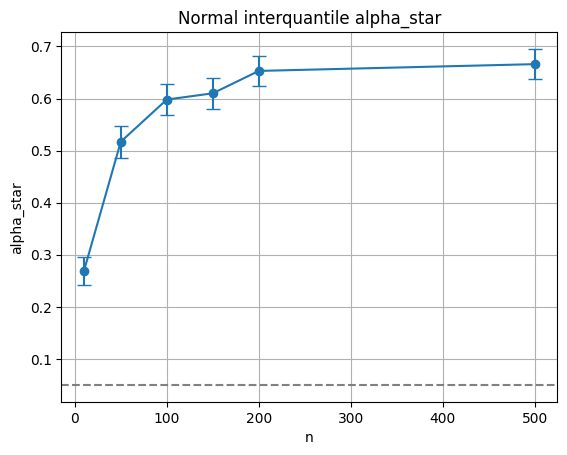

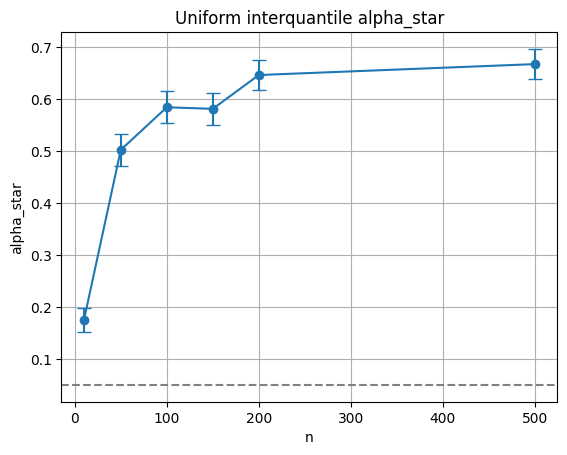

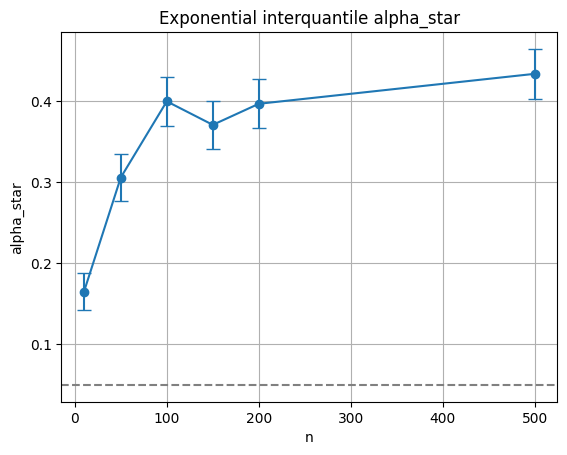

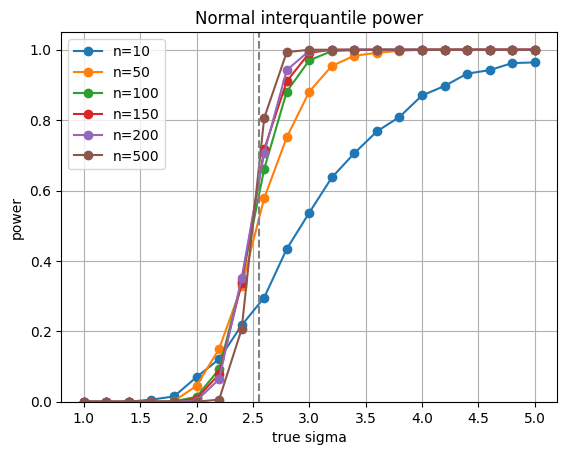

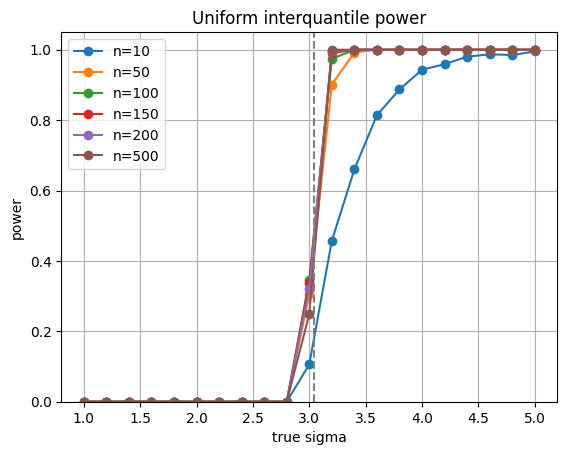

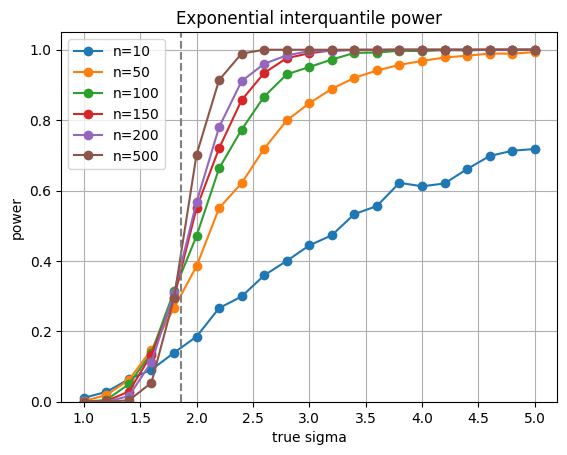

In [3]:
t = 5.0
sigmas = np.arange(1.0, t + 0.001, 0.2)

def q_base(dist_name, p):
    if dist_name == "Normal":
        return float(st.norm.ppf(p))
    if dist_name == "Uniform":
        a = -math.sqrt(3.0)
        b =  math.sqrt(3.0)
        return a + (b - a) * p
    if dist_name == "Exponential":
        return -1.0 - math.log(1.0 - p)
    raise ValueError

def sigma_boundary(dist_name, t):
    q025 = q_base(dist_name, 0.025)
    q975 = q_base(dist_name, 0.975)
    return min(t / q975, (-t) / q025)

def reject_iqr_inside(x, t):
    q025 = float(np.quantile(x, 0.025))
    q975 = float(np.quantile(x, 0.975))
    return (q025 < -t) or (q975 > t)

def simulate_alpha_star_iqr(dist_name, gen):
    alpha_star, ci_lo, ci_hi = [], [], []
    s0 = sigma_boundary(dist_name, t)

    for n in ns:
        rej = 0
        for _ in range(N):
            x = gen(n) * s0
            if reject_iqr_inside(x, t):
                rej += 1
        phat = rej / N
        se = math.sqrt(max(0.0, phat * (1.0 - phat) / N))
        ci_lo.append(max(0.0, phat - z_095 * se))
        ci_hi.append(min(1.0, phat + z_095 * se))
        alpha_star.append(phat)

    return np.array(alpha_star), np.array(ci_lo), np.array(ci_hi), s0

def simulate_power_iqr(gen, n):
    power = []
    for s in sigmas:
        rej = 0
        for _ in range(N):
            x = gen(n) * s
            if reject_iqr_inside(x, t):
                rej += 1
        power.append(rej / N)
    return np.array(power)

iqr_alpha_results = {}
iqr_power_results = {}

for name, gen in dists.items():
    a_star, lo, hi, s0 = simulate_alpha_star_iqr(name, gen)
    iqr_alpha_results[name] = (a_star, lo, hi, s0)
    iqr_power_results[name] = {n: simulate_power_iqr(gen, n) for n in ns}

for name in dists.keys():
    a_star, lo, hi, s0 = iqr_alpha_results[name]
    plt.figure()
    plt.errorbar(ns, a_star, yerr=[a_star - lo, hi - a_star], fmt="o-", capsize=5)
    plt.axhline(alpha, linestyle="--", color="gray")
    plt.xlabel("n")
    plt.ylabel("alpha_star")
    plt.title(name + " interquantile alpha_star")
    plt.grid(True)
    plt.show()

for name in dists.keys():
    plt.figure()
    for n in ns:
        plt.plot(sigmas, iqr_power_results[name][n], marker="o", label="n=" + str(n))
    plt.axvline(iqr_alpha_results[name][3], linestyle="--", color="gray")
    plt.xlabel("true sigma")
    plt.ylabel("power")
    plt.title(name + " interquantile power")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

Проверка условия попадания 95%-го интерквантильного промежутка в интервал [−t, t] часто отвергает нулевую гипотезу: реальный уровень ошибки первого рода существенно превышает заданный и растёт с увеличением размера выборки. При этом мощность критерия быстро возрастает при превышении порогового значения сигмы и тем быстрее, чем больше объём выборки, а характер поведения сохраняется для всех рассмотренных распределений.